# Ungraded Lab: Generating Text with Neural Networks

For this week, you will look at techniques to prepare data and build models for text generation. You will train a neural network with lyrics from an Irish song then let it make a new song for you. Though this might sound like a more complex application, you'll soon see that the process is very similar to the ones you've been using in the previous weeks. Only minor modifications are needed. Let's see what these are in the next sections.

## Imports

First, you will import the required libraries. You've used all of these already in the previous labs.

In [1]:
import tensorflow as tf
import numpy as np

# Basics of how to work and make the next word predictor
### Step-by-Step Breakdown

1. **Corpus Preparation**:
   - **Divide the Corpus**: Split the entire text corpus into lines (or sentences). This will be your input data.
   - **Text Vectorization**: Use a text vectorization method (like TensorFlow's `TextVectorization` layer) to create a vocabulary from the entire corpus. This converts each line into a sequence of integers, where each integer corresponds to a word in the vocabulary.

2. **Padding**:
   - **Pad Sequences**: After vectorizing, ensure that all sequences (lines) have the same length by padding them to the maximum sequence length found in the corpus. This is typically done using a padding function that adds zeros (or other specified values) to the beginning or end of shorter sequences.

3. **N-grams Creation**:
   - **Create N-grams**: For each line, create n-grams. For example, for n=3, you’d take sequences of three words at a time. You can generate overlapping n-grams, which helps the model learn context better.
   - **Pre-padding**: When preparing for n-grams, you can pre-pad your sequences to ensure that they are of the same length.

4. **Training Data Preparation**:
   - **Input (X) and Target (Y)**: For each n-gram sequence:
     - **X**: Take the first n-1 words as input.
     - **Y**: The target is the nth word, which is the next word that should be predicted.
   - **One-Hot Encoding**: Use one-hot encoding for the target (Y) using a method like `to_categorical`, which transforms the target word index into a one-hot encoded vector. The size of this vector will equal the vocabulary size.

5. **Neural Network Input**:
   - **Input Shape**: The input shape for your neural network will be `(max_seq_length - 1,)`, since you are providing the first n-1 words as input and trying to predict the n-th word.
   - **Embedding Layer**: The input goes through an embedding layer that converts the integer sequences into dense vectors of fixed size.
   - **LSTM Layer (or other RNNs)**: After embedding, the data is passed through LSTM layers (or other architectures like GRU or simple RNNs) to capture sequential dependencies and context.
   - **Dense Output Layer**: The final dense layer will have a number of neurons equal to the vocabulary size. This layer outputs a probability distribution over the vocabulary for the next word prediction. The activation function will typically be softmax.

### Example Model Architecture

Here's a simplified implementation of how you might set up such a model using TensorFlow/Keras:

```python
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define hyperparameters
vocab_size = 10000  # Define vocabulary size
embedding_dim = 100  # Define embedding dimension
max_seq_length = 10  # Define max sequence length (for n-grams)
n_gram = 3  # Define n for n-grams

# Example: prepare your input and target data
# Assuming 'texts' is a list of strings (lines from the corpus)
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Create n-grams
input_sequences = []
for sequence in sequences:
    for i in range(1, len(sequence) - n_gram + 1):
        n_gram_sequence = sequence[i - 1:i + n_gram - 1]
        input_sequences.append(n_gram_sequence)

# Prepare input (X) and target (Y)
X = [seq[:-1] for seq in input_sequences]  # All but last word for input
Y = [seq[-1] for seq in input_sequences]  # Last word for target

# One-hot encoding the targets
Y = tf.keras.utils.to_categorical(Y, num_classes=vocab_size)

# Pad sequences to max length
X = pad_sequences(X, maxlen=max_seq_length - 1, padding='pre')

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length - 1))
model.add(LSTM(128))  # or other RNN layers like GRU
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X, Y, epochs=10, batch_size=64)
```

### Summary

1. **Data Preparation**: Break down the text into n-grams, padding and preparing X and Y appropriately.
2. **Model Building**: Construct a sequential model with an embedding layer, RNN (LSTM), and a dense output layer.
3. **Training**: Train the model on the prepared dataset to learn the next-word predictions.

This approach is a strong basis for building next-word prediction models, leveraging the strengths of RNN architectures and embeddings to effectively capture and predict language patterns.

# some imp info
### Key Points for Building a Next-Word Predictor Using RNNs

1. **Data Preparation**:
   - **N-gram Creation**: For each line, create overlapping n-grams to help the model learn context better. Each n-gram consists of the first \( n-1 \) words as input and the nth word as the target.
   - **Padding**: Ensure all sequences are padded to a uniform length (e.g., `max_seq_length - 1`), allowing the model to process batches effectively.

2. **Model Architecture**:
   - **Input Layer**: Accepts sequences of a fixed length (e.g., `max_seq_length - 1`).
   - **Embedding Layer**: Converts the integer sequences into dense vectors, allowing the model to learn word representations.
   - **Recurrent Layers**: 
     - **LSTM Layers**: Use LSTM layers to capture long-term dependencies in the sequences. However, using only LSTM may limit the context since it processes inputs in one direction.
     - **Bidirectional LSTM**: Consider using Bidirectional LSTMs to capture dependencies in both forward and backward directions, providing the model with richer context for each word in the sequence.
   - **Dense Output Layer**: A dense layer with the number of neurons equal to the vocabulary size outputs a probability distribution for the next word prediction, using a softmax activation function.

3. **Training Considerations**:
   - **Epochs**: Set a higher number of epochs (e.g., 500) for training, especially when working with smaller datasets, to allow the model sufficient time to converge.
   - **Loss Function**: Use categorical cross-entropy as the loss function because the target labels are one-hot encoded, reflecting the model’s output distribution across the vocabulary.

4. **Prediction Process**:
   - **Generating New Sequences**: 
     - When generating new text, start with a seed sentence and vectorize it.
     - Pad the sequence to the required length and feed it into the model to predict the next word.
     - Use `np.argmax` to get the index of the word with the highest predicted probability, and append this word to the input sequence.
     - Repeat the process iteratively to continue generating text until the desired length is reached.
   - **Challenges with Generation**: As more words are predicted, the chances of producing less coherent text increase. Each word is predicted based on the model’s learned probabilities, which may lead to compounding errors in longer sequences.

5. **Importance of a Large Corpus**: 
   - The performance of the model heavily depends on the size and quality of the training corpus. A larger, more diverse corpus can improve the model's ability to understand context and produce meaningful predictions.
   - **Tuning the Neural Network**: Experiment with different hyperparameters (e.g., number of LSTM units, dropout rates, learning rates) and architecture modifications to improve the model’s performance further.

### Summary

1. **Model Training**: Train the model with enough epochs to ensure convergence, particularly with smaller datasets.
2. **Bidirectional Context**: Use bidirectional LSTMs to capture context from both directions, enhancing the model's understanding of the sequence.
3. **Loss Function**: Use categorical cross-entropy for one-hot encoded targets.
4. **Text Generation**: Implement a loop for generating new text, understanding that longer generated sequences may introduce errors due to the compounding nature of predictions.
5. **Large Corpus**: Utilize a large and diverse dataset to improve model performance and generalization.

This structured approach, with attention to these points, will enhance the effectiveness of your next-word prediction model using RNNs or LSTMs.
go through next notebooks to get good understanding

## Building the Word Vocabulary

The dataset is the lyrics of [*Lanigan's Ball*](https://en.wikipedia.org/wiki/Lanigan%27s_Ball), a traditional Irish song. You will split it per line then use a `TextVectorization` layer to build the vocabulary.

In [2]:
# Define the lyrics of the song
data = "In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

# Split the long string per line and put in a list
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

['in the town of athy one jeremy lanigan ', ' battered away til he hadnt a pound. ', 'his father died and made him a man again ', ' left him a farm and ten acres of ground. ', 'he gave a grand party for friends and relations ', 'who didnt forget him when come to the wall, ', 'and if youll but listen ill make your eyes glisten ', 'of the rows and the ructions of lanigans ball. ', 'myself to be sure got free invitation, ', 'for all the nice girls and boys i might ask, ', 'and just in a minute both friends and relations ', 'were dancing round merry as bees round a cask. ', 'judy odaly, that nice little milliner, ', 'she tipped me a wink for to give her a call, ', 'and i soon arrived with peggy mcgilligan ', 'just in time for lanigans ball. ', 'there were lashings of punch and wine for the ladies, ', 'potatoes and cakes; there was bacon and tea, ', 'there were the nolans, dolans, ogradys ', 'courting the girls and dancing away. ', 'songs they went round as plenty as water, ', 'the harp tha

In [3]:
# Initialize the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization()

# Build the vocabulary
vectorize_layer.adapt(corpus)

You can view the results with the cell below. The resulting vocabulary is 262 words (not including the special tokens for padding and out-of-vocabulary words). You will these variables later.

In [4]:
# Get the vocabulary and its size
vocabulary = vectorize_layer.get_vocabulary()
vocab_size = len(vocabulary)

print(f'{vocabulary}')
print(f'{vocab_size}')

['', '[UNK]', 'and', 'the', 'a', 'in', 'all', 'i', 'for', 'of', 'lanigans', 'ball', 'were', 'at', 'to', 'stepped', 'she', 'they', 'his', 'girls', 'as', 'weeks', 'up', 'til', 'three', 'there', 'that', 'round', 'out', 'her', 'he', 'got', 'boys', 'again', 'was', 'steps', 'spent', 'new', 'long', 'learning', 'him', 'when', 'wall', 'tipped', 'time', 'them', 'their', 'soon', 'relations', 'put', 'old', 'nice', 'myself', 'miss', 'merry', 'me', 'leg', 'left', 'just', 'from', 'friends', 'fainted', 'dublin', 'dancing', 'danced', 'away', 'an', 'your', 'young', 'youll', 'youd', 'would', 'with', 'wink', 'wine', 'who', 'whirligig', 'went', 'we', 'water', 'under', 'twist', 'twas', 'town', 'tore', 'took', 'too', 'together', 'through', 'think', 'then', 'terrible', 'terrance', 'ten', 'tea', 'taras', 'table', 'swore', 'sweetheart', 'sweet', 'sure', 'suppose', 'stretched', 'strangled', 'squeezed', 'sounded', 'songs', 'some', 'so', 'smashed', 'small', 'singing', 'saw', 'satisfaction', 'same', 'runctions', 'r

## Preprocessing the Dataset

As discussed in the lectures, you will take each line of the song and create inputs and labels from it. For example, if you only have one sentence: "I am using Tensorflow", you want the model to learn the next word given any subphrase of this sentence:

```
INPUT              LABEL
-----------------------------
I             ---> am
I am          ---> using
I am using    ---> Tensorflow
```

The next cell shows how to implement this concept in code. The result would be inputs as padded sequences, and labels as one-hot encoded arrays.

In [5]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Generate the integer sequence of the current line
	sequence = vectorize_layer(line).numpy()

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(sequence)):

		# Generate the subphrase
		n_gram_sequence = sequence[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

Check the result for the first line of the song. The particular line and the expected token sequence is shown in the cell below:

In [6]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(vocabulary.index(word))

# Print the token list
print(token_list)

sample sentence: ['in', 'the', 'town', 'of', 'athy', 'one', 'jeremy', 'lanigan']
[5, 3, 83, 9, 255, 140, 183, 174]


Since there are 8 tokens here, you can expect to find this particular line in the first 7 elements of the `xs` that you generated earlier. If we get the longest subphrase generated, that should be found in `xs[6]`. See the padded token sequence below:

In [7]:
def sequence_to_text(sequence, vocabulary):
  '''utility to convert integer sequence back to text'''

  # Loop through the integer sequence and look up the word from the vocabulary
  words = [vocabulary[index] for index in sequence]

  # Combine the words into one sentence
  text = tf.strings.reduce_join(words, separator=' ').numpy().decode()

  return text

In [8]:
# Pick element
elem_number = 6

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')


token list: [  0   0   0   5   3  83   9 255 140 183]
decoded to text:    in the town of athy one jeremy


If you print out the label, it should show `174` because that is the next word in the phrase (i.e. `lanigan`). See the one-hot encoded form below. You can use the [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method to get the index of the 'hot' label.

In [9]:
# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

one-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index of label: 174


If you pick the element before that, you will see the same subphrase as above minus one word:

In [10]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [  0   0   0   0   5   3  83   9 255 140]
decoded to text:     in the town of athy one
one-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index of label: 183


## Build the Model

Next, you will build the model with basically the same layers as before. The main difference is you will remove the sigmoid output and use a softmax activated `Dense` layer instead. This output layer will have one neuron for each word in the vocabulary. So given an input token list, the output array of the final layer will have the probabilities for each word.

In [11]:
# Build the model
model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(max_sequence_len-1,)),
            tf.keras.layers.Embedding(vocab_size, 64),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
            tf.keras.layers.Dense(vocab_size, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 40)             │        13,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 264)            │        10,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,320 (161.41 KB)

 Trainable params: 41,320 (161.41 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

You can now train the model. We have a relatively small vocabulary so it will only take a couple of minutes to complete 500 epochs.

In [12]:
# Train the model
history = model.fit(xs, ys, epochs=500)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0076 - loss: 5.5731  
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0522 - loss: 5.5413
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0391 - loss: 5.4652   
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0231 - loss: 5.2822   
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0337 - loss: 5.0908
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0523 - loss: 5.0274
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0484 - loss: 5.0095   
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0466 - loss: 4.9683
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0509 - loss: 4.9172
Epoch 10/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0697 - loss: 4.9514
Epoch 11/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0890 - loss: 4.8415
Epoch 12/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

You can visualize the results with the utility below. With the default settings, you should see around 95% accuracy after 500 epochs.

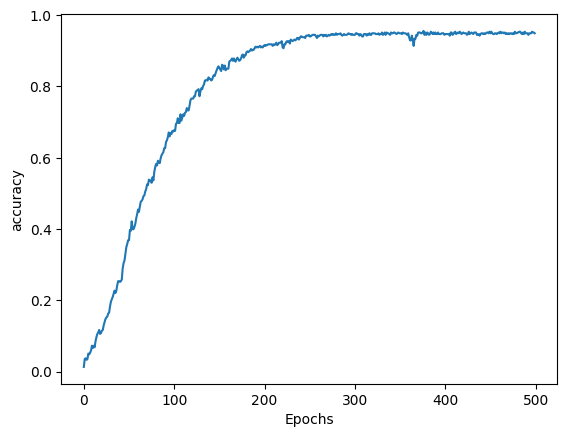

In [13]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

With the model trained, you can now use it to make its own song! The process would look like:

1. Feed a seed text to initiate the process.
2. Model predicts the index of the most probable next word.
3. Look up the index in the reverse word index dictionary
4. Append the next word to the seed text.
5. Feed the result to the model again.

Steps 2 to 5 will repeat until the desired length of the song is reached. See how it is implemented in the code below:

In [14]:
# Define seed text
seed_text = "Laurence went to Dublin"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to an integer sequence
	sequence = vectorize_layer(seed_text)

	# Pad the sequence
	sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(sequence, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = vocabulary[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

Laurence went to Dublin a end to ball all again nelly room and call call friends got were hall kerrigan kerrigan i daughter glisten had nelly died the call suppose died gray gray me me didnt me me entangled a jig jig painted painted big rose call call glisten replied me me me her as a rose call call able big rose glisten glisten glisten replied me me me steps her a call call call able gathered ball ball them them them the punch the table table ladies nolans dolans ogradys ladies glisten glisten glisten nelly jig glisten glisten nelly polkas hearty hall hall


In the output above, you might notice frequent repetition of words the longer the sentence gets. There are ways to get around it and the next cell shows one. Basically, instead of getting the index with max probability, you will get the top three indices and choose one at random. See if the output text makes more sense with this approach. This is not the most time efficient solution because it is always sorting the entire array even if you only need the top three. Feel free to improve it and of course, you can also develop your own method of picking the next word.

In [15]:
# Define seed text
seed_text = "Laurence went to Dublin"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to an integer sequence
  sequence = vectorize_layer(seed_text)

	# Pad the sequence
  sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(sequence, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

    # Look up the word associated with the index.
    output_word = vocabulary[predicted]

    # Combine with the seed text
    seed_text += " " + output_word

# Print the result
print(seed_text)

Laurence went to Dublin a end to her her me time as ball ball ball as rose hullabaloo ball call a rose happened mccarthy happened happened glisten happened eyes eyes mchugh died at entangled me me didnt round me a rose suppose room as a jig arrived call jig glisten glisten had nelly hearty hearty had gray nelly nelly and hearty bacon gray entangled the jig hearty glisten hall mchugh sweetheart lanigan hall happened glisten happened eyes glisten died away me entangled me me round rose rose time a reel a call suppose fainted nelly tea catchers tea catchers relations relations nelly both nelly


## Wrap Up

In this lab, you got a first look at preparing data and building a model for text generation. The corpus is fairly small in this particular exercise and in the next lessons, you will be building one from a larger body of text. See you there!

Run the cell below to free up resources for the next lab.

In [ ]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)